# Homework 3

### By James Kinney and Franklin Marsh

MATH0154
with Prof. 😁Gabe Chandler😁 

My understanding of the MCMC:

In some problems, it does not make sense to use acceptance / rejection sampling, because the target distribution does not overlap much with the "easy" input distribution. Take for example the permutation problem that was described in class. To find the average size of a "Big" permutation (size > some k) of the vector $[1,2,3...,m]$, we need to gather an unbiased sample of "Big" permutations and take their average size. But for reasonable choices of m and k, "Big" permutations such a small fraction of the total number of permutations that they would never be drawn using acceptance sampling.

Thus, we need to start an algorithm in a state we know is Big, and then make small changes to it to see if we can find other Big states. We need to record these in a list and then take their average. We also need to make sure that this algorithm has the time to explore the space of all possible Big permutations, so it is returning us an unbiased list of Big permutations.

We start the algorithm in the biggest state, and then perform a two-swap. This two-swap is likely to generate a permutation that is close in size to the input permutation. We can actually perform all of the possible two swaps, and then check all of those two swaps for swaps with size > k, which we will call "neighbors". We can then move to a new neighbor and repeat this process until all Big permutations are found. But we need to make a slight modification to our algorithm. Some states have more neighbors than others. If we just indiscriminately move forward, we will spend a lot of time in states with many neighbors, and a little time in states with few neighbors. This would bias the resulting average! So, before moving to the new state, we generate a random uniform and only move to the new state with probability $\frac{nOld}{nNew}$. This keeps us from visiting states with lots of neighbors too much.

After we have repeated this process many many times and recording each state we visit, we will have a (close to) unbiased sample of Big permutation sizes, which we can then take the average of.

First, we need to generate $x_{0}$ which is the initial sequence of numbers $[1,2,3...,m]$. The following function generates $x_{0}$ for arbitrary $m$.

In [8]:
GenX0 <- function(m = NULL, initialPerm = NULL) {
    #
    # Function to generate the sequence of the first m positive integers [1,2,3...m]
    #
    # Args:
    #    m: integer length of the sequence
    #    initialPerm: a vector of numbers to be sorted
    # Returns:
    #     x0: sequence integers: [1,2,3...m]
    
    
    # The input should be either an inital permutation of an m
    # If both are given, the m will be used
    if (!is.null(m)){
        return(c(1:m))
    }
    # If m is null, sort the initial vector into increasing order
    else {
        return (sort(initialPerm, decreasing = FALSE))
    }
}


In [9]:
ex_sequence <- GenX0(7) #example sequence
print(ex_sequence) #print the example sequence

[1] 1 2 3 4 5 6 7


To generate a list of vectors that could possibly be neighbors, we need to swap two elements in the initial vector $x_{0}$. For this, we will write a swap function.

In [10]:
Swap <- function (x, i, j) {
    #
    # Function to swap two elements (i,j) in an input vector x.
    #
    # Args:
    #    x: sequence on which to perform the swap.
    #    i: index less than length(x)
    #    j: index less than length(x)
    # Returns:
    #     x_swap: new vector with indices i and j swapped.
    
    tempI <- x[i] # Save the ith element
    x[i] <- x[j] # Change the ith element to the jth element
    x[j] <- tempI # Change the jth element to the ith element
    return (x) # Return the new vector
}


In [11]:
ex_swap <- Swap(ex_sequence, 2, 4) #swap the 2nd element with the 4th element.
print(ex_swap) #print the sequence with the 2nd element and the 4th element swapped.

[1] 1 4 3 2 5 6 7


We will now write a function to generate all of the possible two-element swaps in a vector.

In [12]:
GenSwaps <- function(x) {
    # Generates all m choose 2 possibles 2 elements swaps from a permutation, x.
    #
    # Args:
    #    x: one-dimensional input vector of arbitrary length
    # Returns:
    #    output: matrix where the rows are the all possible permutations achievable via one two-swap.
    # 
    
    output <- matrix(data = NA, nrow = sum((1:length(x))) - (length(x) - 2), ncol = length(x)) #initialize an empty matrix
    index <- 1 #start the looping index at 1
    for (i in (1:length(x))) { #for each element in the input vector
        for (j in ((i+1):length(x) - 1)) { #for each element in the input vector greater than i
        output[index,] <- Swap(x, i, j) # Add a possible swap to the output matrix.
        index <- index + 1 #increase the index by one to move to store the next permutation.
        }
    }
    return(unique(output)) #remove duplicate rows from the output matrix and return it.
}

In [13]:
ex_gen_swaps <- GenSwaps(GenX0(10))
print(ex_gen_swaps)

      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
 [1,]    1    2    3    4    5    6    7    8    9    10
 [2,]    2    1    3    4    5    6    7    8    9    10
 [3,]    3    2    1    4    5    6    7    8    9    10
 [4,]    4    2    3    1    5    6    7    8    9    10
 [5,]    5    2    3    4    1    6    7    8    9    10
 [6,]    6    2    3    4    5    1    7    8    9    10
 [7,]    7    2    3    4    5    6    1    8    9    10
 [8,]    8    2    3    4    5    6    7    1    9    10
 [9,]    9    2    3    4    5    6    7    8    1    10
[10,]    1    3    2    4    5    6    7    8    9    10
[11,]    1    4    3    2    5    6    7    8    9    10
[12,]    1    5    3    4    2    6    7    8    9    10
[13,]    1    6    3    4    5    2    7    8    9    10
[14,]    1    7    3    4    5    6    2    8    9    10
[15,]    1    8    3    4    5    6    7    2    9    10
[16,]    1    9    3    4    5    6    7    8    2    10
[17,]    1    2    4    3    5 

We will need to find the size of every possible swap created by GenSwaps. The size of a vector $V$ is defined as: $\sum_{i}^{m}i \times V_{i}$, where $m$ is the length of the vector $V$.

In [14]:
FindSize <- function(x) {
    #
    # Function to check the size of a permutation
    #
    # Args:
    #    x: permutation to find the size of
    # Returns:
    #    size: size of the permutation, as defined: $\sum_{i}^{m}i \times V_{i}$
 
  sizes <- c()   # Input is a vector of the permutation in order
  for (j in (1:length(x))) {   # Loop through each index of the permutation and multiply by the index
    sizes[j] <- x[j]*j     # Store these values in a vector
  }
  return(sum(sizes))   # Return the sum of the vector of products
}

We see that the two vectors that we previously generated have different size.

In [15]:
print(FindSize(ex_sequence))
print(FindSize(ex_swap))

[1] 140
[1] 136


Using our recently-built size function, and our list of possible swaps, we need to determine two things. First, we need to determine which permutations are actually neighbors (having size > k). Then we need to determine the length of this list of neighbors. We will write two separate functions to do this.

In [31]:
NeighborMatrix <- function(swap_matrix, k) {
    #
    # produces a matrix of permutations of size > k.
    #
    # Args:
    #    swap_matrix: the matrix with all of the possible two-swaps of a given vector as rows
    #    k: the minimum size of a "big" permutation.
    # Returns:
    #    out: matrix with permutations of size > k as rows.
    
    sizes <- apply(swap_matrix, 1, FindSize) #apply findsize function across the rows 
    
    return(swap_matrix[as.logical(sizes > k),]) #return a matrix with only the neighbors as rows.
}

NumberGreaterThanK <- function(swap_matrix, k) {
    #
    # produces an integer number of permutations of the input with size > k
    #
    # Args:
    #    swap_matrix: the matrix with all of the possible two-swaps of a given vector as rows
    #    k: the minimum size of a "big" permutation.
    # Returns:
    #    out: integer of number of permutations with size > k.
    
    sizes <- apply(swap_matrix, 1, FindSize) #apply findsize function across the rows 
    
    return(length(sizes[as.logical(sizes > k)])) #return the number of neighbors
}

For example, we can use our example generated swaps and k = 380 to find the number of neighbors:

In [17]:
print(NumberGreaterThanK(ex_gen_swaps, 380))

[1] 17


In this next line, we demonstrate the function which selects only the neighbors from the list of possible two-swaps:

In [18]:
neighbor_matrix <- NeighborMatrix(ex_gen_swaps, 380)
print(neighbor_matrix)

      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
 [1,]    1    2    3    4    5    6    7    8    9    10
 [2,]    2    1    3    4    5    6    7    8    9    10
 [3,]    3    2    1    4    5    6    7    8    9    10
 [4,]    1    3    2    4    5    6    7    8    9    10
 [5,]    1    4    3    2    5    6    7    8    9    10
 [6,]    1    2    4    3    5    6    7    8    9    10
 [7,]    1    2    5    4    3    6    7    8    9    10
 [8,]    1    2    3    5    4    6    7    8    9    10
 [9,]    1    2    3    6    5    4    7    8    9    10
[10,]    1    2    3    4    6    5    7    8    9    10
[11,]    1    2    3    4    7    6    5    8    9    10
[12,]    1    2    3    4    5    7    6    8    9    10
[13,]    1    2    3    4    5    8    7    6    9    10
[14,]    1    2    3    4    5    6    8    7    9    10
[15,]    1    2    3    4    5    6    9    8    7    10
[16,]    1    2    3    4    5    6    7    9    8    10
[17,]    1    2    3    4    5 

Out of a vector of neighbors, we need to pick one at random. This is our candidate permutation, which we might move to in the next Markov Chain step.

In [19]:
RandomNeighbor <- function (neighbors) {
    #
    # Produces a random neighbor from an input matrix of neighbors
    # Input is a vector of the neighbors
    index <- sample((1:nrow(neighbors)),1) #pick a random row number from the neighbors matrix
    return (neighbors[index,]) #return the row corresponding to the randomly selected index.
}

For example:

In [20]:
RandomNeighbor(neighbor_matrix) #pick an example random neighbor

[1]  1  2  3  4  6  5  7  8  9 10

In order for the MCMC to run for a long time, we want to bias the algorithm to move towards states with fewer neighbors. We need to count the number of neighbors of a beginning state X and and ending state Y and compare them. Then we will draw a random uniform and compare it to the ratio of (nX/nY). If $u < \frac{nX}{nY}$, we will move to the candidate state. If not, we will stay where we are and try to move to another neighbor in the same manner.

In [34]:
ChangeCheck <- function (nX, nY) {
    #
    # Produces TRUE if the MCMC algorithm says to move to the new state and FALSE if not
    #
    # Args:
    #    nX: the number of neighbors of the permutation x
    #    nY: the number of neighbors of the permutation y
    # Returns:
    #    change_boolean: boolean of whether to move to the state y from x

    if (nX >= nY) {   # If n(x) is greater than n(Y) always switch
        return (TRUE)
    }

    else {   # Otherwise switch with probability n(x)/n(y)
        p <- nX/nY
        u <- runif(1, 0, 1) # Create a unif between 0 and 1 and if it is less than n(x)/n(y) switch
    }
    
    if (u <= p) {
      return (TRUE)
    }
    else {
      return (FALSE)
    }
}


This next Step function perforsm the bulk of the MCMC. It puts together what we have previously written. It takes in an input vector, and finds all the neighbors of that input vector. It then performs a two-swap to produce a candidate vector. It then finds all of the neighbors of the candidate vector. It then decides whether to move to the candidate vector by comparing the number of neighbors with the number of neighbors of the input vector. It returns a vector that is the next vector in the MCMC chain.

In [22]:
Step <- function(x,k) {
    #
    # Produces the next iteration in an MCMC algorithm, if given the input permutation x and the size of a "big" permutation k.
    #
    # Args:
    #    x: input permutation
    #    k: minimum size of a "big" permutation
    # Returns:
    #    out: next step in the MCMC algorithm.
    
    x_swaps <- GenSwaps(x) #generate the possible swaps for the first vector
    neighbors <- NeighborMatrix(x_swaps, k) #find the swaps that are neighbors
    y <- RandomNeighbor(neighbors) #pick a random swap
    y_swaps <- GenSwaps(y) #generate the possible for swaps for the candidate vector.
    nX <- NumberGreaterThanK(x_swaps, k) #calculate the number of neighbors of the first vector.
    nY <- NumberGreaterThanK(y_swaps, k) #calculate the number of neighbors of the candidate vector.
    change_bool <- ChangeCheck(nX,nY) #decide whether to move to the candidate vector.
    
    if (change_bool == TRUE) {
        return(y)
    }

    else if (change_bool == FALSE) {
        return(x)
    }
}

This next function does a lot of MCMC steps, recording the vector of each step in a list, and then returning us that list.

In [35]:
MCMC <- function(m,k,n_iters) {
    #
    # Args:
    #    m: the length of the initial x0 vector [1,2,3...m]
    #    k: the minimum size for a 'big' permutation.
    #    n_iters: number of MCMC iterations that is desired.
    # Returns:
    #    out: list of states that the MCMC has visited.
    
    x0 <- list(GenX0(m)) #generate the first vector

    for (i in (1:n_iters + 1)) { #for each iteration
        x0[[i]] <- Step(x0[[i-1]],k) #perform an MCMC step and record the outcome
    }
    return(t(simplify2array(x0)))
}

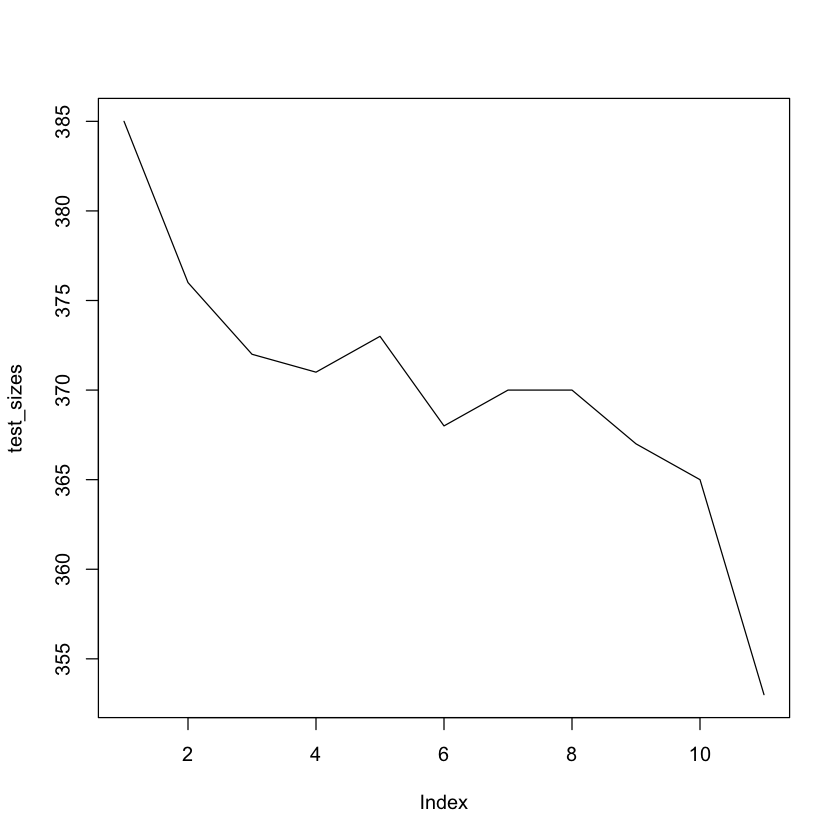

In [46]:
test_MCMC <- MCMC(10,350,10) #run the MCMC and store the list of states in a variable
test_sizes <- apply(test_MCMC, 1, FindSize) # loop through the rows (permutations) and record the sizes 
plot(test_sizes, type = 'l') #plot size as a function of MCMC iteration

In the above figure, there is a generally decreasing trend of size with iteration number. This is an indication that the MCMC has not "settled in" on an equilibrium state. We started the MCMC from the permutation with largest size - this is not a likely size as there is only one permutation with this size. A sign that we have sufficiently explored the space of "big" permutations is that the mean size of the permutations does not change with index.

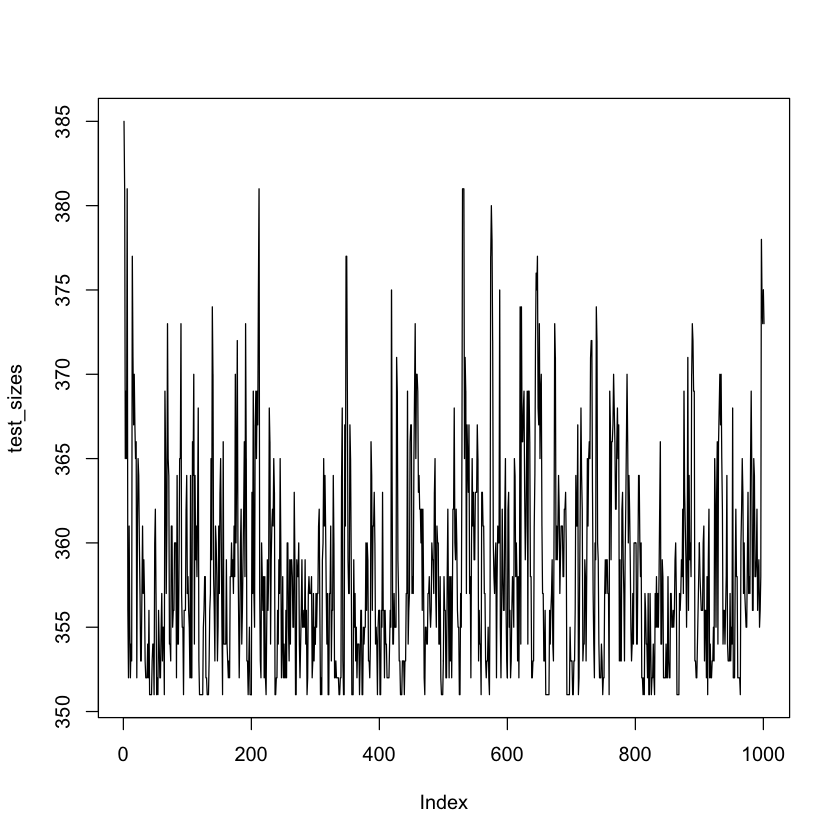

In [47]:
test_MCMC <- MCMC(10,350,1000) #run the MCMC and store the list of states in a variable
test_sizes <- apply(test_MCMC, 1, FindSize) # loop through the rows (permutations) and record the sizes 
plot(test_sizes, type = 'l') #plot size as a function of MCMC iteration

In the above figure, we see that there is not a trend in size with index, because we have let the MCMC run "long enough". In fact, we can "burn in" the algorithm, which means deleting the first few iterations to remove the bias that comes from starting in the largest state. In the next line, we will only show the last 900 iterations.

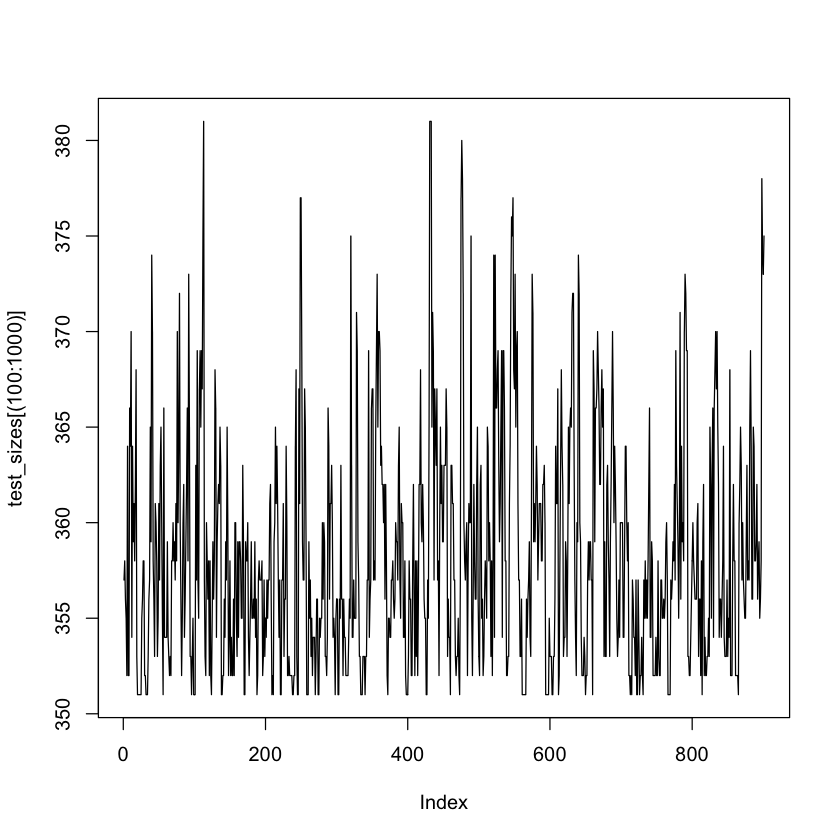

In [49]:
plot(test_sizes[(100:1000)], type = 'l')

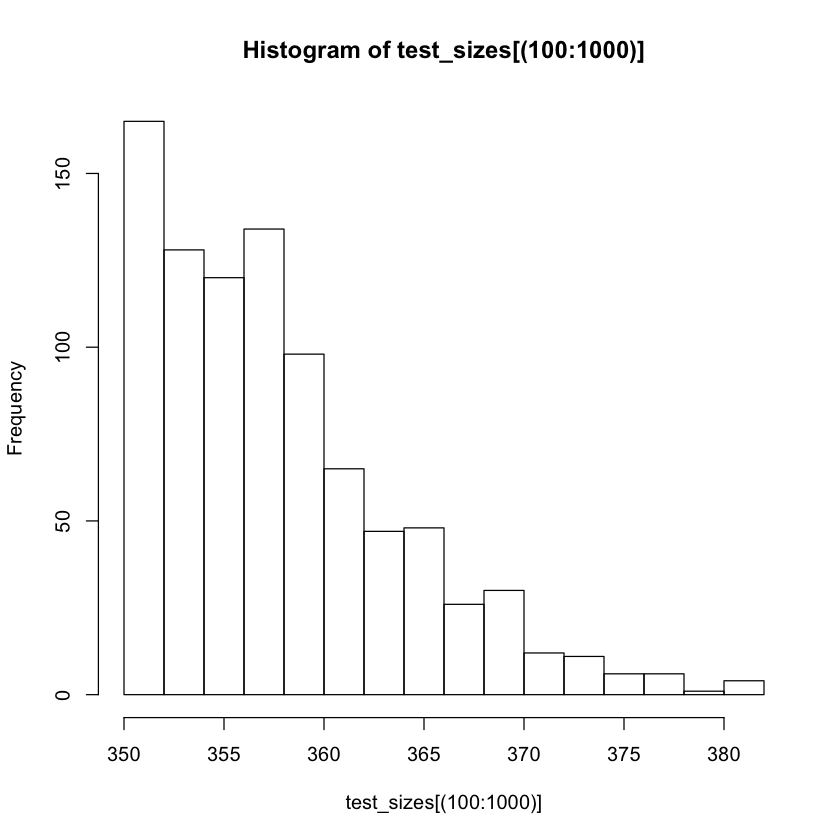

In [50]:
hist(test_sizes[(100:1000)]) #examine the distribution of sizes in the MCMC iteration list

In [51]:
print(mean(test_sizes[(100:1000)])) #compute the average size of a "big" permutation

[1] 358.2497


There we have it, folks!  👏 🙌 🍻 